### Importing Libraries:

In [178]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords

### Importing dataset :

In [179]:
train_news = pd.read_csv('data/train.csv.zip', index_col = False)
test_news = pd.read_csv('data/test.csv.zip', index_col = None)

### Resulting dataframe

In [180]:
train_news = train_news.drop('id', axis = 1).copy()

### Dataset Exploration

In [181]:
train_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   text    20761 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 650.1+ KB


In [182]:
train_news.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

There are several columns with null values that we must treat

In [183]:
train_news.dtypes

title     object
author    object
text      object
label      int64
dtype: object

All the data types are correct.

In [184]:
train_news.head(10)

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


#### Is the dataset balanced?

In [185]:
train_news.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

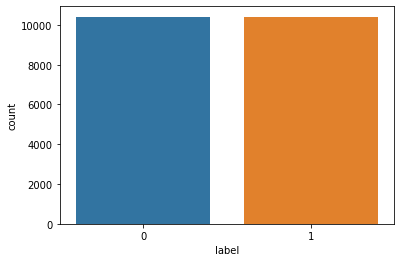

In [186]:
sns.countplot(train_news['label'])

The dataset is balanced and has pretty much the same number of fake and real news.

#### Finding duplicates

In [187]:
train_news['duplicate'] = train_news.duplicated(subset=['text'])

In [188]:
train_news.groupby(['duplicate', 'label']).label.count()

duplicate  label
False      0        10387
           1        10000
True       1          413
Name: label, dtype: int64

In [189]:
"""The dataset is balanced and there are almost no duplicates, also, the data types are correct. 
There are several null values that we must take a look into"""

'The dataset is balanced and there are almost no duplicates, also, the data types are correct. \nThere are several null values that we must take a look into'

#### Dropping duplicates 

In [190]:
train_news.loc[train_news['duplicate'] == True]

,title,author,text,label,duplicate
169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1,True
295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1,True
470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1,True
480,Watch: Muslim ‘Palestinians’ Declare “We follo...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1,True
573,Le top des recherches Google passe en top des ...,NaN,NaN,1,True
...,...,...,...,...,...
20728,Trump warns of World War III if Clinton is ele...,NaN,Email Donald Trump warned in an interview Tues...,1,True
20749,Realities Faced by Black Canadians are a Natio...,Anonymous,"Tweet Widget by Robyn Maynard \nCanada, includ...",1,True
20750,Why Did Four Googles Kill This White?,Andrew Anglin,Migrant Crisis Disclaimer \nWe here at the Dai...,1,True
20754,No More American Thanksgivings,Glen Ford,Thanksgiving by Glen Ford \n“The core ideologi...,1,True


In [191]:
train_news = train_news.drop((train_news.loc[train_news['duplicate'] == True].index))

#### Treating Null Values

In [192]:
train_news.isnull().sum()

title         518
author       1854
text            1
label           0
duplicate       0
dtype: int64

In [193]:
train_news.loc[train_news['text'].isnull()]

,title,author,text,label,duplicate
142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1,False


All this news have no text or author + they are in french, which would make our algorithm to work innacurately since most of our news are in english. We will then drop this rows. 

In [194]:
train_news = train_news.drop((train_news.loc[train_news['text'].isnull()].index).copy())

In [195]:
train_news.loc[train_news['author'].isnull()]

,title,author,text,label,duplicate
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,False
8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,False
20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1,False
23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,False
31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1,False
...,...,...,...,...,...
20690,Способен ли кто-нибудь помешать Соросу стать «...,NaN,Регион: США в мире Как отмечает в своей новой ...,1,False
20718,This Is The Best Picture In Human History | Da...,NaN,This Is The Best Picture In Human History By: ...,1,False
20745,Thomas Frank Explores Whether Hillary Clinton ...,NaN,Thomas Frank Explores Whether Hillary Clinton ...,1,False
20768,Osama bin Laden’s older brother rents out luxu...,NaN,Osama bin Laden’s older brother rents out luxu...,1,False


The author column is not on our other dataset, so it shouldn't be too important, however we are going to 
see if the Fake News are the ones without author

In [196]:
train_news.loc[train_news['author'].isnull()]['label'].value_counts()

1    1827
0      26
Name: label, dtype: int64

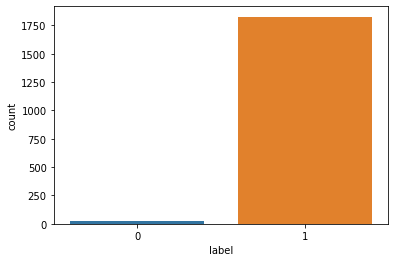

In [197]:
sns.countplot(train_news.loc[train_news['author'].isnull()]['label'])

Most of the news that have not an author are fake. So instead dropping this lines, we are going to replace them 
with the value Anonymous, since it could be a key column for our algorithm

In [198]:
train_news['author'] = train_news['author'].replace(np.nan, 'Anonymous').copy()

In [199]:
train_news.isnull().sum()

title        518
author         0
text           0
label          0
duplicate      0
dtype: int64

Last, we have to treat the null values from the title. Let's check out how many rows also come from an Anonymous source. In that case, we will drop them because the information provided originally was too little. 
Otherwise, we won't drop them since the title and the text are going to be analized together.

In [200]:
train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')]

,title,author,text,label,duplicate
120,NaN,Anonymous,"Same people all the time , i dont know how you...",1,False
140,NaN,Anonymous,There is a lot more than meets the eye to this...,1,False
562,NaN,Anonymous,Field is correct about the 8a companies and Tr...,1,False
1322,NaN,Anonymous,Georg Soros the good oil . http://mailstar.net...,1,False
2559,NaN,Anonymous,The green fraud has a lot to do with it all as...,1,False
2671,NaN,Anonymous,"Hell thats a good speech , maybe there is more...",1,False
3247,NaN,Anonymous,"Everybody send it to Drudge, infowars lets see...",1,False
3309,NaN,Anonymous,Haha! Your Hillary agents are writing this cru...,1,False
3398,NaN,Anonymous,"He has got to go after him , he is the one cau...",1,False
3945,NaN,Anonymous,Its not a bad idea paiting their faces same as...,1,False


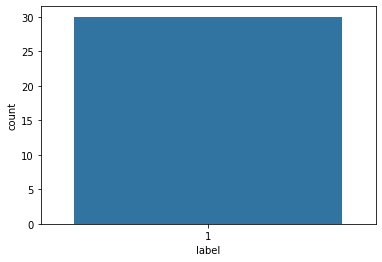

In [201]:
sns.countplot(train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')]['label'])

In [202]:
#dropping these rows

train_news = train_news.drop((train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')].index))

In [203]:
train_news.isnull().sum()

title        488
author         0
text           0
label          0
duplicate      0
dtype: int64

In [204]:
train_news.loc[train_news.title.isnull()].label.value_counts()

1    488
Name: label, dtype: int64

All the news without a title are fake news. Let's try to see how much would dropping this rows affect our dataset or we can extract this info from other columns

In [205]:
train_news.loc[train_news.title.isnull()]

,title,author,text,label,duplicate
53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1,False
124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1,False
196,NaN,Raffie,They got the heater turned up on high.,1,False
223,NaN,PhilSilversGhost,If I were one of those Guardsmen and the Spets...,1,False
288,NaN,beersession,The way he's doing business there seems he'll ...,1,False
...,...,...,...,...,...
20568,NaN,Cathy Milne,"Amusing comment Gary! “Those week!” So, are ...",1,False
20627,NaN,Ramona,"No she doesn’t have more money than God, every...",1,False
20636,NaN,Dave Lowery,Trump all the way!,1,False
20771,NaN,Letsbereal,DYN's Statement on Last Week's Botnet Attack h...,1,False


In [206]:
train_news.loc[(train_news.author.str.contains('The')) & (train_news.author.str.len() >= 30) & (train_news.title.isnull())]

,title,author,text,label,duplicate


These rows have no info at all about the title, we can drop these files to create a df with title and text separate, and maintain them in another dataset where we put together the title and text.

##### Creating dataset with title and text separated; dropping files with null title.

- df1 is the Dataset where rows and are clean and we have title and text separated.

In [207]:
df1 = train_news.drop((train_news.loc[train_news.title.isnull()].index).copy())

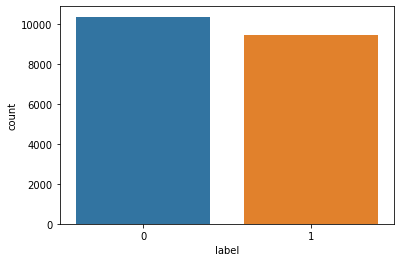

In [208]:
sns.countplot(df1['label'])

In [209]:
df1 = df1.drop('duplicate', axis = 1)

- df2 is the Dataset where rows are clean and we have one single column for text.

In [210]:
df2 = train_news[['author','text','label']]

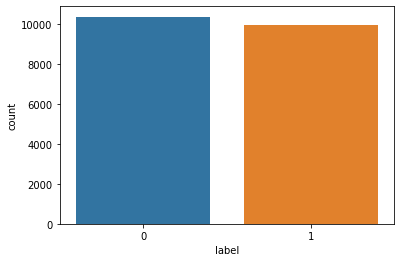

In [211]:
sns.countplot(df2['label'])

### Resulting dataset

In [212]:
train_news.head(10)

,title,author,text,label,duplicate
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,False
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,False
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,False
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,False
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,False
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,False
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Anonymous,Ever wonder how Britain’s most iconic pop pian...,1,False
7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,False
8,Excerpts From a Draft Script for Donald Trump’...,Anonymous,Donald J. Trump is scheduled to make a highly ...,0,False
9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,False


In [213]:
train_news = train_news.drop(['duplicate'], axis=1)

In [214]:
train_news = train_news[['author', 'title', 'text', 'label']]

In [215]:
train_news = train_news.drop((train_news.loc[train_news.title.isnull()].index).copy())

In [216]:
train_news.isnull().sum()

author    0
title     0
text      0
label     0
dtype: int64

### Cleaning a little bit deeper

### Can we detect languages to make sure all our dataset is in English?

In [217]:
import cld3

languages= []
for text in train_news.text:
    r = cld3.get_language(text)
    languages.append(r.language)

In [218]:
train_news['language'] = languages
train_news.loc[(train_news.language != 'en') & (train_news.label == 1)]

,author,title,text,label,language
47,Anonymous,"СМИ Сербии приписали россиянам ""подготовку тер...",0 комментариев 0 поделились Фото: AP \nОднако ...,1,ru
82,Steve Sailer,Huma’s Weiner Dogs Hillary,,1,ja
173,Guest,Trump family already ‘sworn to secrecy’ about ...,Guest Guest,1,fr
229,Anonymous,США—КНР: на кого возлагать ответственность за ...,Страна: Китай Заявления КНДР о завершении свое...,1,ru
233,Xavi Puig,"La expresión “no, lo siguiente” ya es la más u...","La expresión “no, lo siguiente” ya es la más u...",1,es
...,...,...,...,...,...
20690,Anonymous,Способен ли кто-нибудь помешать Соросу стать «...,Регион: США в мире Как отмечает в своей новой ...,1,ru
20704,Denis Tarasow,Kunst am Werk: Wie UralMasch zur Bilder-Galeri...,Audio-Slideshows Kunst am Werk: Wie UralMasch ...,1,de
20714,Tomás Fuentes,¿Quién es quién en el nuevo Consejo de Ministros?,"Objetivos: El tema catalán, que intentará reso...",1,es
20740,noreply@blogger.com (Der Postillon),Kleiner Vorgeschmack: Erdogan lässt Warnflücht...,"Freitag, 25. November 2016 Kleiner Vorgeschmac...",1,de


In [219]:
print(f'The ratio of articles not in english is :' ,len(train_news.loc[train_news.language != 'en']) / len(train_news.language))

The ratio of articles not in english is : 0.026172740084558083


Since most of our dataset refers to political news in the USA, and it's in english, we are opting to drop these rows even if they are mostly of fake news. We are going to be focusing onhaving a model that is able to predict fake and true news in USA. For a balanced model about different countries or languages, we would need a much more bigger and balanced dataset.

In [220]:
train_news = train_news.drop(train_news.loc[train_news.language != 'en'].index).copy()

In [221]:
train_news = train_news.drop('language', axis =1)

In [222]:
train_news.to_csv('data/clean_news.csv')

In [223]:
df1 = train_news.drop((train_news.loc[train_news.title.isnull()].index).copy())

In [224]:
df1.to_csv('data/df1.csv')

In [225]:
df2 = train_news[['author','text','label']]

In [226]:
df2.to_csv('data/df2.csv')

In [227]:
len(df1)

19348

In [228]:
len(df2)

19348

### Which topics are the most important ones and what words are repeated more often?

In [229]:
text = " ".join(article for article in train_news.text)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 91681018 words in the combination of all review.


In [230]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["don't", "do", "said","one"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

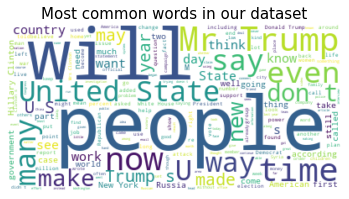

In [231]:
# Display the generated image:
# the matplotlib way:

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words in our dataset', fontsize=15)
plt.show()

Most of the words refer either to normal words or the US, Trump, American,etc. Let's see if it makes a difference the word depending if they are real or fake.

In [232]:
text_real = " ".join(article for article in train_news.loc[train_news['label']==0].text)
print ("There are {} words in the combination of all review.".format(len(text_real)))

text_fake = " ".join(article for article in train_news.loc[train_news['label']==1].text)
print ("There are {} words in the combination of all review.".format(len(text_fake)))

There are 54156164 words in the combination of all review.
There are 37524853 words in the combination of all review.


In [233]:
# Generate a word cloud image
wordcloud_real = WordCloud(stopwords=stopwords, background_color="white").generate(text_real)
wordcloud_fake = WordCloud(stopwords=stopwords, background_color="white").generate(text_fake)

Text(0.5, 1.0, 'Most common words in Real News')

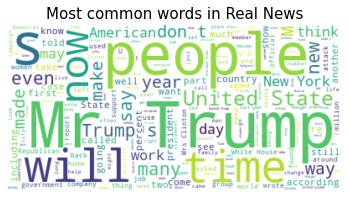

In [234]:
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words in Real News', fontsize=15)

Text(0.5, 1.0, 'Most common words in Fake News')

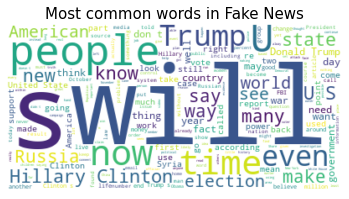

In [235]:
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words in Fake News', fontsize=15)

### What do we now about our authors column?

In [236]:
train_news.author.value_counts().sort_values(ascending=False).tail(50)

Pamela Druckerman                                                                    1
Niraj Chokshi and Liam Stack                                                         1
Pamela Gwyn Kripke                                                                   1
Alexander Mercouris                                                                  1
Landon Thomas Jr., Liz Alderman and Aurelien Breeden                                 1
Bonnie Wertheim                                                                      1
Michael S. Schmidt and Mark Landler                                                  1
William Brandon Shanley                                                              1
Maggie Haberman and Kate Zernike                                                     1
Roger I. Roots, J.D., Ph.D.                                                          1
Goldbug                                                                              1
Vasa Croe                                  

In [237]:
train_news.author.replace('admin', 'Anonymous', inplace=True)

In [238]:
train_news.loc[(train_news.author.str.contains('The')) & (train_news.author.str.len() >= 30), 'author'] = 'Anonymous'

### Creating a news column for the source feature of our dataset, since there are lot of sources as authors

In [239]:
#creating a news column called sources
train_news['source'] = ''

If the author is longer than three words, then it is not an author, but the title of the article itself. 
Also, if the author contains the word "The", it is likely to be the source, and not the author. 

In [240]:
#creating a list of sources
sources = train_news.loc[(train_news.author.str.contains('The')) & (train_news.author.str.len() >= 20)].author

In [241]:
train_news.loc[(train_news.author.str.contains('The')) & (train_news.author.str.len() >= 20), 'author']

148          The European Union Times
287       The New York Times Magazine
498          The European Union Times
554          The European Union Times
790      The Common Constitutionalist
                     ...             
19399        The European Union Times
19402        The European Union Times
20023     The Conservative Millennial
20435        The Free Thought Project
20530     The Conservative Millennial
Name: author, Length: 152, dtype: object

For the str that contains The, we notice that all of them are newspapers, so we instead place that the author is unknown and then we populate the source.

In [242]:
train_news['source'] = train_news[train_news['author'].isin(sources)].author

In [243]:
train_news.loc[(train_news.author.str.contains('The')) & (train_news.author.str.len() >= 20), 'author'] = 'Anonymous'

We have notices that there are a lot of authors categorized as Breitbart, when that is indeed, a source, let's solve that

In [244]:
train_news['source'] = train_news[train_news['author'].isin(train_news.loc[(train_news.author.str.contains('Breitbart')), 'author'])]

In [245]:
train_news.loc[(train_news.author.str.contains('Breitbart')), 'author'] = 'Anonymous'

In [246]:
train_news.author.value_counts().sort_values(ascending=False)

Anonymous                                             2420
Pam Key                                                243
Jerome Hudson                                          166
Charlie Spiering                                       141
John Hayward                                           140
                                                      ... 
Jonah Weiner                                             1
Eric Lipton, Matthew Rosenberg and Nicholas Fandos       1
Michael Barbaro and Noah Remnick                         1
Aurelien Breeden and Lilia Blaise                        1
Bashar al-Assad                                          1
Name: author, Length: 3698, dtype: int64

In [247]:
train_news.loc[train_news['author'].isin(['BareNakedIslam','Activist Post','IWB','King World News','shorty']), 'author'] = 'Anonymous'


In [248]:
train_news.loc[train_news.author.str.contains('Anonymous')].source.isnull().sum()

2443

In [249]:
train_news.loc[train_news['author'].str.contains('noreply@blogger.com')].author.value_counts()

noreply@blogger.com (Alexander Light)      80
Dikran Arakelian (noreply@blogger.com)     51
Jafe Arnoldski (noreply@blogger.com)       42
Arnold Monteverde (noreply@blogger.com)    41
tokyowashi (noreply@blogger.com)           14
Tom Winter (noreply@blogger.com)           11
Inessa S (noreply@blogger.com)              9
Kristina Rus (noreply@blogger.com)          1
Name: author, dtype: int64

In [250]:
#replacing the author of blogger.com for null value 
train_news['author'] = train_news['author'].map(lambda x: x.lstrip('noreply@blogger.com').rstrip('aAbBcC'))
train_news['author'] = train_news['author'].map(lambda x: x.replace('(noreply@blogger.com)',''))

#replacing the author for anonymous and replacing those values in the source
train_news['source'] = train_news.loc[train_news['author'].str.contains('com'), 'author'].map(lambda x: re.findall('([A-Za-z_0-9.]+.).com', x))
train_news.loc[train_news['author'].str.contains('com'), 'author'] = 'Anonymous'

### Let's look at how our columns author and source look after all this cleaning

In [251]:
train_news.author.value_counts()

#since most of the column is made if Anonymous authors, let's make it a boolean, Anonymous = 1 and author written = 0

Anonymous                             2894
Pam Key                                243
Jerome Hudson                          166
Charlie Spiering                       141
John Hayward                           140
                                      ... 
isegesis                                 1
Rana F. Sweis                            1
Douglass Price                           1
Patrick Healy and Thomas Kaplan          1
Katrin Bennhold and Stephen Castle       1
Name: author, Length: 3667, dtype: int64

In [252]:
train_news['author'] = [0 if value != 'Anonymous' else 1 for value in train_news.author]

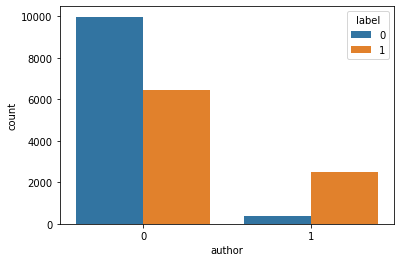

In [253]:
sns.countplot(x= 'author', hue= 'label', data = train_news)

Almost all the news with no authors are fake, but news with authors can also be fake. Also, most of the source values are new, so we will leave the cleaning of the source for the future. 

In [255]:
train_news.source.isnull().sum()

19195

In [258]:
df_news = train_news[['title','text','author','label']]

In [259]:
df_news.head()

,title,text,author,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,0,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,0,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,0,1


In [260]:
#saving our clean dataset for the preprocessing and modeling part.
df_news.to_csv('data/clean_news.csv')

In [262]:
df2.head()

,author,text,label
0,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [263]:
#saving a dataset with text combined 

df2['author'] = df_news['author']

<ipython-input-263-d1af4d848d97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['author'] = df_news['author']


In [264]:
df2.head()

,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,0,Ever get the feeling your life circles the rou...,0
2,1,"Why the Truth Might Get You Fired October 29, ...",1
3,0,Videos 15 Civilians Killed In Single US Airstr...,1
4,0,Print \nAn Iranian woman has been sentenced to...,1


In [265]:
df2.to_csv('data/clean_news_notitle.csv')